In [1]:
# importing python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
from plotnine import * 
from plotnine.data import mtcars
import venn
from scipy import stats
import seaborn as sns
import math
from scipy.stats import pearsonr
import abc
import batchglm.api as glm
import logging
import patsy
from random import sample
import scipy.sparse
from typing import Union, Dict, Tuple, List, Set
import math
from anndata import AnnData
from typing import Optional, Union, Mapping  # Special
from typing import Sequence, Collection, Iterable  # ABCs
_VarNames = Union[str, Sequence[str]]

%matplotlib inline
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.5 umap==0.5.1 numpy==1.21.0 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.2 pynndescent==0.5.2


# Anndata to DF function

In [2]:
from pandas.api.types import is_categorical_dtype

In [3]:
def sanitize_anndata(adata):
    adata._sanitize()

In [4]:
def sc_prepare_dataframe(
    adata: AnnData,
    var_names: Union[_VarNames, Mapping[str, _VarNames]],
    groupby: Optional[str] = None,
    use_raw: Optional[bool] = None,
    log: bool = False,
    num_categories: int = 7,
    layer=None,
    gene_symbols: Optional[str] = None,
):
    """
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata
        Annotated data matrix.
    var_names
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    use_raw
        Use `raw` attribute of `adata` if present.
    log
        Use the log of the values
    num_categories
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    gene_symbols
        Key for field in .var that stores gene symbols.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse

    sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None:
        use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError(
                'groupby has to be a valid observation. '
                f'Given {groupby}, valid observations: {adata.obs_keys()}'
            )

    if gene_symbols is not None and gene_symbols in adata.var.columns:
        # translate gene_symbols to var_names
        # slow method but gives a meaningful error if no gene symbol is found:
        translated_var_names = []
        for symbol in var_names:
            if symbol not in adata.var[gene_symbols].values:
                logg.error(
                    f"Gene symbol {symbol!r} not found in given "
                    f"gene_symbols column: {gene_symbols!r}"
                )
                return
            translated_var_names.append(
                adata.var[adata.var[gene_symbols] == symbol].index[0]
            )
        symbols = var_names
        var_names = translated_var_names
    if layer is not None:
        if layer not in adata.layers.keys():
            raise KeyError(
                f'Selected layer: {layer} is not in the layers list. '
                f'The list of valid layers is: {adata.layers.keys()}'
            )
        matrix = adata[:, var_names].layers[layer]
    elif use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    if gene_symbols is not None:
        # translate the column names to the symbol names
        obs_tidy.rename(
            columns=dict([(var_names[x], symbols[x]) for x in range(len(var_names))]),
            inplace=True,
        )
    categories = obs_tidy.index.categories

    return categories, obs_tidy


# making bubble plot for SS2

In [5]:
def calculate_cell_fraction_on_genes_df(df):
    df_final = pd.DataFrame()
    for i in df.columns.tolist():
        temp_df_initial = df[[i]].rename(columns={i: 'expression'})
        temp_df = temp_df_initial.groupby(level=0).mean()
        temp_df['fraction'] = (temp_df_initial[temp_df_initial['expression'] > 0].groupby(level=0).count())/(temp_df_initial.groupby(level=0).count())*100
        temp_df['gene'] = i
        df_final = df_final.append(temp_df)
    
        
    return df_final

In [6]:
adata_processed = sc.read_h5ad('SS2_processed.h5ad')

In [7]:
adata_processed

AnnData object with n_obs × n_vars = 2090 × 34041
    obs: 'plate_ID', 'well', 'cell_id', 'Tumor_ID', 'Animal_ID', 'receptor_status', 'ER_receptor', 'intrinsic_BC_type', 'metastatic_potential_rank', 'metastatic_potential_group', 'sort', 'n_counts', 'n_genes', 'percent_ERCC', 'percent_mito', 'percent_ribo', 'sequencing_batch', 'S_score', 'G2M_score', 'phase', 'louvain', 'leiden', 'E_score', 'M_score', 'EMP_score', 'EMP_stage'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'EMP_stage_colors', 'ER_receptor_colors', 'Tumor_ID_colors', 'hvg', 'intrinsic_BC_type_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'ranking_ID_colors', 'receptor_status_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_procssed_tumor = adata_processed[adata_processed.obs['sort'] == 'Tumor']
adata_procssed_met = adata_processed[adata_processed.obs['sort'] == 'Metastatic']

tumor_expression_df = sc_prepare_dataframe(adata_procssed_tumor, ['ESR1','PGR','ERBB2','AR'], groupby='Tumor_ID',use_raw=True)
met_expression_df = sc_prepare_dataframe(adata_procssed_met, ['ESR1','PGR','ERBB2','AR'], groupby='Tumor_ID',use_raw=True)

In [9]:
tumor_expression_df[1]

,ESR1,PGR,ERBB2,AR
Tumor_ID,,,,
J53353,0.000000,0.0,1.637394,0.0
H4272,0.047752,0.0,0.028924,0.0
HCI011,0.000000,0.0,0.000000,0.0
HCI010,0.000000,0.0,0.575296,0.0
H4272,0.000000,0.0,1.245149,0.0
...,...,...,...,...
H5471,0.000000,0.0,0.000000,0.0
H5471,0.000000,0.0,0.000000,0.0
H5471,0.000000,0.0,0.000000,0.0


In [10]:
tumor_plot = calculate_cell_fraction_on_genes_df(tumor_expression_df[1])
tumor_plot['sort'] = 'Tumor'

met_plot = calculate_cell_fraction_on_genes_df(met_expression_df[1])
met_plot['sort'] = 'Metastatic'

In [11]:
final_plot_df = tumor_plot.append(met_plot)
final_plot_df['Tumor_ID'] = final_plot_df.index
final_plot_df

,expression,fraction,gene,sort,Tumor_ID
Tumor_ID,,,,,
H3204,0.000898,0.800000,ESR1,Tumor,H3204
H4272,0.197061,36.000000,ESR1,Tumor,H4272
H5097,0.221899,30.769231,ESR1,Tumor,H5097
H5471,0.000501,0.393701,ESR1,Tumor,H5471
HCI001,0.009524,6.410256,ESR1,Tumor,HCI001
...,...,...,...,...,...
HCI010,0.000237,1.111111,AR,Metastatic,HCI010
HCI011,0.000262,1.449275,AR,Metastatic,HCI011
J2036,0.000000,0.000000,AR,Metastatic,J2036


In [12]:
tumor_order = ['J55454', 'H5471', 'HCI005', 'H3204', 'H4272', 'HCI009',
    'HCI011', 'HCI001', 'H5097', 'J2036', 'J53353', 'HCI010']

In [13]:
tumor_order.reverse()

In [14]:

final_plot_df['gene'] = pd.Categorical(final_plot_df['gene'], categories=['ESR1','PGR','ERBB2','AR'], ordered=True)
final_plot_df['Tumor_ID'] = pd.Categorical(final_plot_df['Tumor_ID'], categories= tumor_order, ordered=True)
final_plot_df['sort'] = pd.Categorical(final_plot_df['sort'], categories= ['Tumor','Metastatic'], ordered=True)


receptor_plot_ref = (ggplot(final_plot_df,aes(y='Tumor_ID', x='gene',size='fraction', fill='expression')) +
    geom_point(alpha=1,color='gray') + 
    scale_size(name="percentage",range = [0, 20],limits=[0,80],labels=['< 1','20', '40','60', '> 80' ])+ facet_grid('.~ sort')+
    scale_fill_cmap(('Reds'),limits=(0,1)) +
    theme(axis_text_x=element_text(rotation=None, hjust=1),axis_text_y=element_text(size=10, hjust=1),plot_background=element_rect(fill='white', alpha=.3),
          panel_background=element_rect(fill='white', alpha=.2),figure_size=(5, 8),legend_key = element_blank())
    )

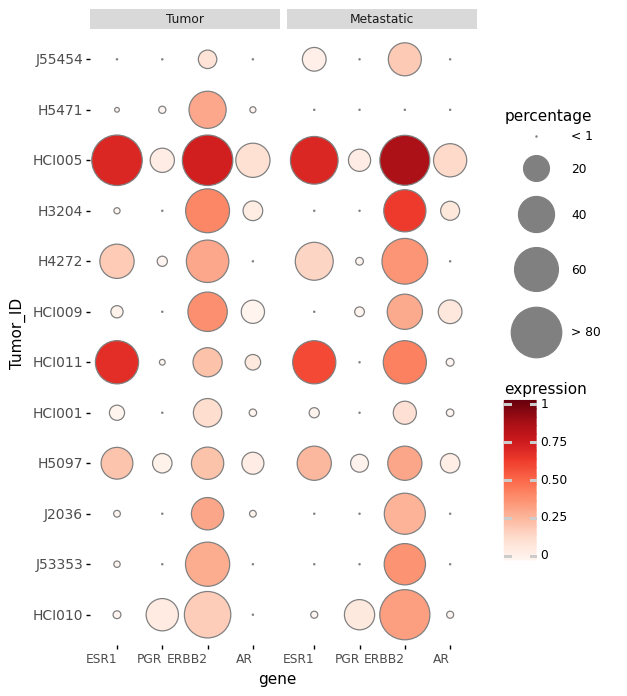

<ggplot: (8746301325412)>

In [15]:
receptor_plot_ref

In [16]:
save_as_pdf_pages([receptor_plot_ref],'receptors_bubble_plot_SS2_ref.pdf')

/home/weilun/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: receptors_bubble_plot_SS2_ref.pdf


In [17]:
receptor_plot = (ggplot(final_plot_df,aes(y='Tumor_ID', x='gene',size='fraction', fill='expression')) +
    geom_point(alpha=1) + guides(fill = None,color=None,size=None) +
    scale_size(name="percentage",range = [0, 20],limits=[0,80],labels=['< 1','20', '40','60', '> 80' ])+ facet_grid('.~ sort')+
    scale_color_manual(['white', 'black'])+ scale_fill_cmap(('Reds'),limits=(0,1)) +
    theme(axis_text_x=element_blank(),axis_text_y=element_blank(),axis_title_x=element_blank(),axis_title_y=element_blank(),
          strip_background=element_blank(), strip_text_x=element_blank(),
          plot_background=element_rect(fill='white', alpha=.3),panel_background=element_rect(fill='white', alpha=.2),figure_size=(5, 8),
          axis_ticks = element_blank())
    )

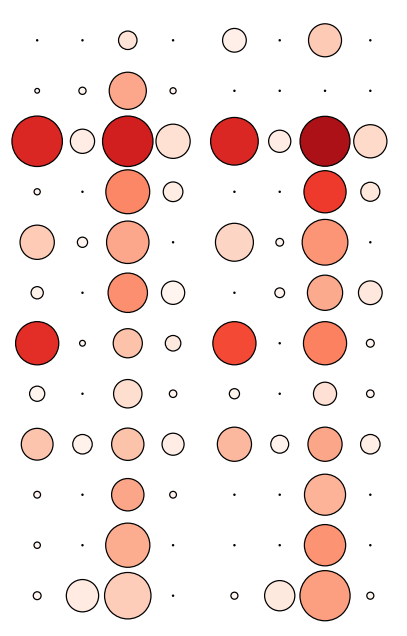

<ggplot: (8746260714885)>

In [18]:
receptor_plot

In [19]:
save_as_pdf_pages([receptor_plot],'receptors_bubble_plot_SS2.pdf')

/home/weilun/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:820: PlotnineWarning: Filename: receptors_bubble_plot_SS2.pdf
